# RADIA Python Example 3: Simple U46 Hybrid Undulator

This example creates and solves a simple U46 Hybrid Undulator made with
rectangular blocks.

To obtain an acceptable precision for the magnetic field, it is essential to
increase the segmentation, which, of course, requires more memory and CPU time.
The initial segmentation in this example has been set to `np = [2,2,5]` for
the pole and `nm = [1,3,1]` for the magnet. These settings yield an absolute
error of order 1% in the peak field of the undulator. The user can vary both
`np` and `nm` (see section Create Geometry) and assess the consequences for
memory usage, CPU time, and convergence of the peak field value. As a rule,
the iron will require finer segmentation, because its magnetization is very
sensitive to the external field.

One can also—for undulators such as this one—compute field integrals and forces
on the magnets and poles. In addition, one build a wedge-pole undulator by using
polyhedrons or extruded polygons instead of rectangular blocks. To learn more,
read the Radia documentation, experiment with the code, and develop experience.

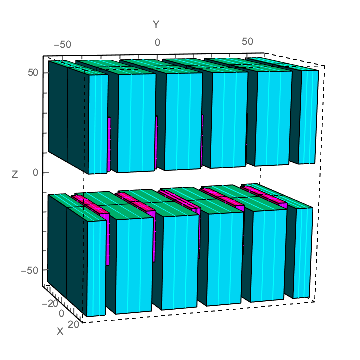

In [1]:
%matplotlib inline
from __future__ import print_function #Py 2.*/3.* compatibility
import radia as rad
import numpy as np
import matplotlib.pyplot as plt
import time as tm
#import uti_plot

# until we have 3D graphics, simply
# import an illustration of this magnet
from IPython.display import Image
Image(filename=('./U46HybridUnd.png'))

We first define a function that constructs the desired magnet geometry in Radia.
The following function builds an array of rectangular permanent magnets with
their mirror symmetric counterparts, distributes the colors, magnetic materials
and sets the segmentation. The function is very generic and can be used to build
almost any hybrid undulator (though without optimizing the design of terminations).

In [3]:
def Und(lp, mp, np, cp, lm, mm, nm, cm, gap, gapOffset, numPer):
    """
    
    """
    zer = [0,0,0]
    Grp = rad.ObjCnt([])

    #Principal Poles and Magnets
    y = lp[1]/4;
    Pole = rad.ObjFullMag([lp[0]/4,y,-lp[2]/2-gap/2], [lp[0]/2,lp[1]/2,lp[2]], zer, np, Grp, mp, cp)
    y += lp[1]/4;

    mDir = -1
    for i in range(0, numPer):
        initM = [0, mDir, 0]; mDir *= -1
        y += lm[1]/2
        Magnet = rad.ObjFullMag([lm[0]/4,y,-lm[2]/2-gap/2-gapOffset], [lm[0]/2,lm[1],lm[2]], initM, nm, Grp, mm, cm)
        y += (lm[1] + lp[1])/2
        Pole = rad.ObjFullMag([lp[0]/4,y,-lp[2]/2-gap/2], [lp[0]/2,lp[1],lp[2]], zer, np, Grp, mp, cp)
        y += lp[1]/2

    initM = [0, mDir, 0]
    y += lm[1]/4;
    Magnet = rad.ObjFullMag([lm[0]/4,y,-lm[2]/2-gap/2-gapOffset], [lm[0]/2,lm[1]/2,lm[2]], initM, nm, Grp, mm, cm)

    #Mirrors
    rad.TrfZerPerp(Grp, [0,0,0], [1,0,0])
    rad.TrfZerPara(Grp, zer, [0,0,1])
    rad.TrfZerPerp(Grp, zer, [0,1,0])
    
    return Grp, Pole, Magnet


In [3]:
def Materials():
    #Defines magnetic materials for the Undulators Poles and Magnets
    #Pole (~iron type Va Permendur) material data
    H = [0.8, 1.5, 2.2, 3.6, 5, 6.8, 9.8, 18, 28, 37.5, 42, 55, 71.5, 80, 85, 88, 92, 100, 120, 150, 200, 300, 400, 600, 800, 1000, 2000, 4000, 6000, 10000, 25000, 40000]
    M = [0.000998995, 0.00199812, 0.00299724, 0.00499548,0.00699372, 0.00999145, 0.0149877, 0.0299774, 0.0499648, 0.0799529, 0.0999472, 0.199931, 0.49991, 0.799899, 0.999893, 1.09989, 1.19988, 1.29987, 1.41985, 1.49981, 1.59975, 1.72962, 1.7995, 1.89925, 1.96899, 1.99874,  2.09749, 2.19497, 2.24246, 2.27743, 2.28958, 2.28973]
    convH = 4.*3.141592653589793e-07
    ma = []
    for i in range(len(H)): ma.append([H[i]*convH, M[i]])
    mp = rad.MatSatIsoTab(ma)

    #(Permanent) Magnet material: NdFeB with 1.2 Tesla Remanent Magnetization
    mm = rad.MatStd('NdFeB', 1.2)

    return mp, mm


def GetMagnMaterCompMvsH(MeshH, ind, cmpnH,  cmpnM):
    #Extracting Magnetization vs Field Strength magnetic material data
    hMin = MeshH[0]; hMax = MeshH[1]; nh = MeshH[2]
    hStep = (hMax - hMin)/(nh - 1)
    M = [0]*nh
    sCmpnM = 'm' + cmpnM
    h = hMin
    H = [0,0,0]
    for i in range(nh):
        if(cmpnH == 'x'): H[0] = h
        elif(cmpnH == 'y'): H[1] = h
        elif(cmpnH == 'z'): H[2] = h
        M[i] = rad.MatMvsH(ind, sCmpnM, H)
        h += hStep
    return M


def CalcField(g, per, numPer):

    #Vertical Magnetic Field vs Longitudinal Position
    yMax = per*(numPer+1)/2.
    yMin = -yMax
    ny = 501
    yStep = (yMax - yMin)/(ny)
    xc = 0
    zc = 0
    y = numpy.arange(yMin, yMin + (ny) * yStep, yStep)
    
    Points = []
    for i in range(ny):
        Points.append([xc, y[i], zc])

    BzVsY = rad.Fld(g, 'bz', Points)

    return BzVsY, [yMin, yMax, ny]

Solved for Magnetization in 0.226274013519s
Relaxation Results: [9.958929076862139e-05, 2.291223586040892, 1.0287951299232179, 156.0]
Peak Magnetic Field: 0.430360615539 5 T


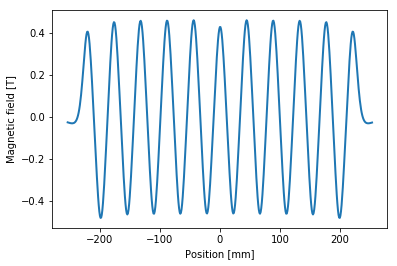

In [4]:
#General Undulator Parameters
gap = 20; numPer = 10; per = 46; gapOffset = 1

#Pole Parameters
lp = [45,5,25]; np = [2,2,5]; cp = [1,0,1]
ll = per/2 - lp[1]

#Magnet Parameters
lm = [65,ll,45]; nm = [1,3,1]; cm = [0,1,1]

#Magnetic Materials
mp, mm = Materials()

#Build the Structure
und, pole, magnet = Und(lp, mp, np, cp, lm, mm, nm, cm, gap, gapOffset, numPer)

#Solve the Magnetization Problem
t0 = time.time()
res = rad.Solve(und, 0.0001, 100000)
t1 = time.time()

print('Solved for Magnetization in ' + str(t1 - t0) + 's')
print('Relaxation Results:', res)
print('Peak Magnetic Field:', rad.Fld(und, 'bz', [0,0,0]), 5, 'T')

# Calculate the magnetic field 
t1 = time.time()
BzVsY, MeshY = CalcField(und, per, numPer)
t2 = time.time()

y = numpy.linspace(MeshY[0], MeshY[1], MeshY[2])
plt.figure()
plt.plot(y, BzVsY, linewidth = 2.0)
plt.xlabel('Position [mm]')
plt.ylabel('Magnetic field [T]')
plt.savefig('example_3_fld.pdf')
plt.show()


501
0.29891204834


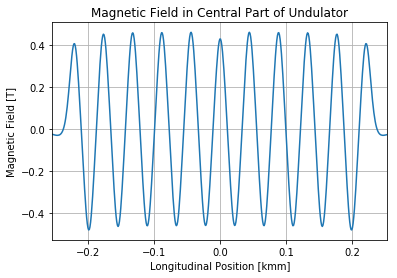

In [7]:
#Calculate Magnetic Field

print(t2 - t1)

#Extracting Characteristics of Magnetic Materials
MeshH_Pole = [-0.002, 0.002, 201]
M_Pole = GetMagnMaterCompMvsH(MeshH_Pole, pole, 'x', 'x')
MeshH_Mag = [-1, 1, 201]
Mpar_Mag = GetMagnMaterCompMvsH(MeshH_Mag, magnet, 'y', 'y')
Mper_Mag = GetMagnMaterCompMvsH(MeshH_Mag, magnet, 'x', 'x')

#Plot the Results

uti_plot.uti_plot1d(BzVsY, MeshY, ['Longitudinal Position', 'Magnetic Field', 'Magnetic Field in Central Part of Undulator'], ['mm', 'T'])
uti_plot.uti_plot_show() #show all graphs (and block further execution, if any)


In [ ]:
#uti_plot.uti_plot1d(M_Pole, MeshH_Pole, ['Magnetic Field Strength (mu0*H)', 'Magnetization', 'Pole Material M vs H'], ['T', 'T'])
#uti_plot.uti_plot1d(Mpar_Mag, MeshH_Mag, ['Magnetic Field Strength (mu0*H)', 'Magnetization Parallel to Easy Axis', 'Permanent Magnet M vs H Parallel to Easy Axis'], ['T', 'T'])
#uti_plot.uti_plot1d(Mper_Mag, MeshH_Mag, ['Magnetic Field Strength (mu0*H)', 'Magnetization Perpendicular to Easy Axis', 'Permanent Magnet M vs H Perpendicular to Easy Axis'], ['T', 'T'])